<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/VIP%3A%20Uncertainty%20Estimation/PyTorch_Uncertainty_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
def generate_batch(batch_size=32):
    x = np.random.random(batch_size) * 10 - 5
    
    sd = 0.05 + 0.1 * (x + 5)
    
    # target = mean + noise * sd
    y = np.cos(x) - 0.3 * x + np.random.randn(batch_size) * sd
    
    return x, y

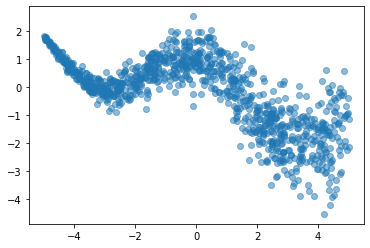

In [3]:
# visualize the data
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.ann1 = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )
        self.ann2 = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )
        
    def forward(self, inputs):
        # returns (mean, log-variance)
        return self.ann1(inputs), self.ann2(inputs)

In [5]:
model = Model()

In [6]:
def criterion(outputs, targets):
    mu = outputs[0]
    v = torch.exp(outputs[1])
    
    # coefficient term
    c = torch.log(torch.sqrt(2 * np.pi * v))
    
    # exponent term
    f = 0.5 / v * (targets - mu) ** 2
    
    # mean log-likelihood
    nll = torch.mean(c + f)
    
    return nll

In [7]:
optimizer = torch.optim.Adam(model.parameters())

In [8]:
n_epochs = 5000
batch_size = 128
losses = np.zeros(n_epochs)

for i in range(n_epochs):
    x, y = generate_batch(batch_size)
    
    inputs = torch.from_numpy(x).float().view(-1, 1)
    targets = torch.from_numpy(y).float().view(-1, 1)
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    losses[i] = loss.item()
    
    if i % 1000 == 0:
        print("Epoch: {}, Loss: {}".format(i, loss.item()))
    
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 1.8089091777801514
Epoch: 1000, Loss: 1.0127328634262085
Epoch: 2000, Loss: 0.9138502478599548
Epoch: 3000, Loss: 0.7223032116889954
Epoch: 4000, Loss: 0.7190914750099182


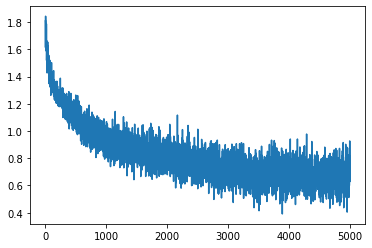

In [9]:
plt.plot(losses)

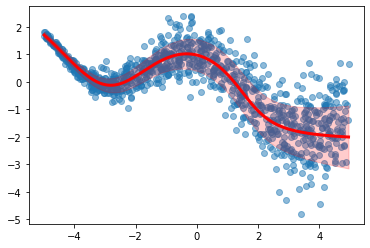

In [10]:
# plot the model predictions
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5)

inputs = torch.from_numpy(x).float().view(-1, 1)
targets = torch.from_numpy(y).float().view(-1, 1)

with torch.no_grad():
    outputs = model(inputs)
    yhat = outputs[0].numpy().flatten()
    sd = np.exp(outputs[1].numpy().flatten() / 2)
    
idx = np.argsort(x)
plt.plot(x[idx], yhat[idx], linewidth=3, color='red')
plt.fill_between(x[idx], yhat[idx] - sd[idx], yhat[idx] + sd[idx], alpha=0.2, color='red')
plt.show()